# PART 1: Complexity Hotspots

### 1. You must consider only the app folder from the Mastodon repository
(i.e., https://github.com/mastodon/mastodon).

In [2]:
import pydriller
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import pickle
import os

### 2. Decide on the granularity of your analysis of software entities (e.g., source code files); describe why you selected this specific granularity.

In [36]:
# run inside \mastodon\app
git ls-files | awk -F . '{print $NF}' | sort | uniq -c | sort -n -r | awk '{print $2,$1}' | head -10
rb 895
js 437
haml 214
json 178
png 37
erb 33
scss 32
svg 24
woff2 5
woff 5

<i> .rb means ruby files, these are the most common files in the app folder. </i>

### 3. Create a list of all these entities, as they appear in the latest stable release of Mastodon (i.e., tag v3.5.3). 

<i> **Number of entities for tagged v3.5.3.**

First we change to that version with the command "git checkout tags/v3.5.3".
Then we create a pydriller git object to obtain the number of files we had at that time.
We can also find the defined entities with the following commands: </i>

In [ ]:
git checkout tags/v3.5.3
cd app
find . -type f -name "*.rb" | awk -F / '{print $(NF)}' > mastodon_rubyfiles.txt

In [4]:
mastodon_path = "C:\\Users\\szymo\\Desktop\\SOSy_repos\\mastodon"
mastodon_app_path = os.path.join(mastodon_path, "app")
git = pydriller.git.Git(mastodon_path)
files = git.files()
total=[]
for file in files:
    if mastodon_app_path in file and ".rb" in file:
        total.append(file)
entities = []
for f in total:
    entities.append(f.split("\\")[-1])
print("Total number of entities for tag v3.5.3: ", len(entities))

# save entities to pickle
with open('entities.pickle', 'wb') as handle:
    pickle.dump(entities, handle, protocol=pickle.HIGHEST_PROTOCOL)

Total number of entities for tag v3.5.3:  815


In [9]:
# OTHER VERSION - to be corrected?

repository = pydriller.Repository(mastodon_path, to_tag="v3.5.3")
latest_release_commits = list(repository.traverse_commits())
files = {}
for commit in latest_release_commits:
    for m in commit.modified_files:
        # keep only files with .rb extension
        if m.filename.endswith('.rb'):
            # FILE IS ADDED 
            if m.new_path is not None and m.old_path is None:
                # example:  m.new_path = 'app/sth.rn' & old_path = None
                files[m.new_path] = m.filename
            # FILE IS DELETED
            elif m.new_path is None and m.old_path is not None:
                # example:  m.new_path = None         & old_path = 'app/sth.rn'
                files[m.old_path] = 'deleted'
            # else:
            #     if m.new_path != m.old_path:
            #         print(m)
            #         files[m.new_path] = m.filename
            #         files[m.old_path] = 'deleted'

# keep only files that are not deleted
files_filtered = {k: v for k, v in files.items() if v != 'deleted'}

# keep only the files that are in app/ 
files_entities = {k: v for k, v in files_filtered.items() if k.startswith('app\\')}

# get just the names
files_entities_names = list(files_entities.values())
print("Number of files: ", len(files_entities_names))

Number of files:  825


### 4. Decide on the type of complexity you want to measure for your software entities and explain why you selected this type.

<i> We decided to use the Cyclomatic Complexity. It is a quantitative measure of the number of linearly independent paths inside the code and is defined as “the amount of decision logic in a source code function”. Meaning the more decisions a function has, the more complex it is.

In case the code does not have any control flow statements, the cyclomatic complexity is 1. If we have a single if statement, the cyclomatic complexity is 2 - one path for TRUE and one for FALSE. 

For example, if source code contains no control flow statement then its cyclomatic complexity will be 1 and source code contains a single path in it. Similarly, if the source code contains one if condition then cyclomatic complexity will be 2 because there will be two paths one for true and the other for false. 

PyDriller uses Cyclomatic Complexity to calculate the complexity of the code. </i>


### 5. Decide on a timeframe on which you want to base your analysis and explain the rationale of your choice.

The time interval chosen was guided by the versions indicated in the different tags. We analyzed the entities defined from the code version tagged as v3.0.0 to version v3.5.3. We assume that version 3.0.0 corresponds to a code version after a major change. Thus, version 3.5.3 has been reached by a series of minor changes and fixes and, consequently, this version and all intermediate versions correspond to a change over a code without major technical and logical differences.

In [5]:
# needed to run only once to create a file
mastodon_path = "C:\\Users\\szymo\\Desktop\\SOSy_repos\\mastodon"
repo = pydriller.Repository(mastodon_path, from_tag="v3.0.0", to_tag="v3.5.3")
with open('repo.pkl', 'wb') as f:
    pickle.dump(repo, f)

In [6]:
# open the Repository file
with open('repo.pkl', 'rb') as f:
    repo = pickle.load(f)

# open the entities file
with open('entities.pickle', 'rb') as handle:
    entities = pickle.load(handle)

### 6. For each entity in the system, measure its complexity and the number of changes (in the given timeframe). Merge these two pieces of information together to create a candidate list of problematic hotspots in the app part of Mastodon.
### 7. Visualize the hotspots with a visualization of your choice.

In [7]:
# from the commits that belong to the interval between the chosen tags, 
# we extract the information to know the changed entities and their complexities
file_changes = {}
file_complexities = {}
for c in repo.traverse_commits():
    for mf in c.modified_files:
        if mf.filename not in file_changes:
            file_changes[mf.filename] = 1
            file_complexities[mf.filename] = [mf.complexity]
        else:
            file_changes[mf.filename] += 1  
            file_complexities[mf.filename].append(mf.complexity)

# save file_changes to pickle
with open('file_changes.pickle', 'wb') as handle:
    pickle.dump(file_changes, handle, protocol=pickle.HIGHEST_PROTOCOL)
# save file_complexities to pickle
with open('file_complexities.pickle', 'wb') as handle:
    pickle.dump(file_complexities, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
entity_changes = {}
entity_complexities = {}
for fc in file_changes:
    if fc in entities:
        entity_changes[fc] = file_changes[fc]
        entity_complexities[fc] = file_complexities[fc]

In [9]:
# the dictionary entity_changes contains the entities that have changed in the analyzed interval
# as keys and the number of times that they have changed as values
entity_changes = {k: v for k, v in sorted(entity_changes.items(), key=lambda item: item[1], reverse=True)}

In [10]:
# save entity_changes to pickle
with open('entity_changes.pickle', 'wb') as handle:
    pickle.dump(entity_changes, handle, protocol=pickle.HIGHEST_PROTOCOL)
# save entity_complexities to pickle
with open('entity_complexities.pickle', 'wb') as handle:
    pickle.dump(entity_complexities, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# mean number of changes
mean_changes = np.mean(list(entity_changes.values()))
print("Mean number of changes: ", round(mean_changes, 2))

# compute the mean complexity for each entity omit None 
mean_complexities = {}
for ec in entity_complexities:
    mean_complexities[ec] = np.mean([x for x in entity_complexities[ec] if x is not None])
mean_complexities = {k: v for k, v in sorted(mean_complexities.items(), key=lambda item: item[1], reverse=True)}
mean_complexity = np.mean(list(mean_complexities.values()))
print("Mean complexity: ", round(mean_complexity, 2))

Mean number of changes:  3.7
Mean complexity:  11.47


In [12]:
def plot_complexity_trend(entity, index):
    plt.subplot(10, 2, index)
    plt.tick_params(axis='both', labelsize=8)
    plt.plot(entity_complexities[entity], marker="o")
    plt.axhline(y=mean_complexities[entity], color='r', linestyle='-', label="mean complexity of " + entity)
    plt.title("Complexity trend - " + entity.replace('_', ' '), fontsize=15)
    plt.xlabel(r"$Commits$", fontsize=10)
    plt.ylabel(r"$Complexity$", fontsize=10)
    plt.legend(loc='best', prop={'size': 8}, title="Mean complexity of entities: " + str(round(mean_complexity,2)))

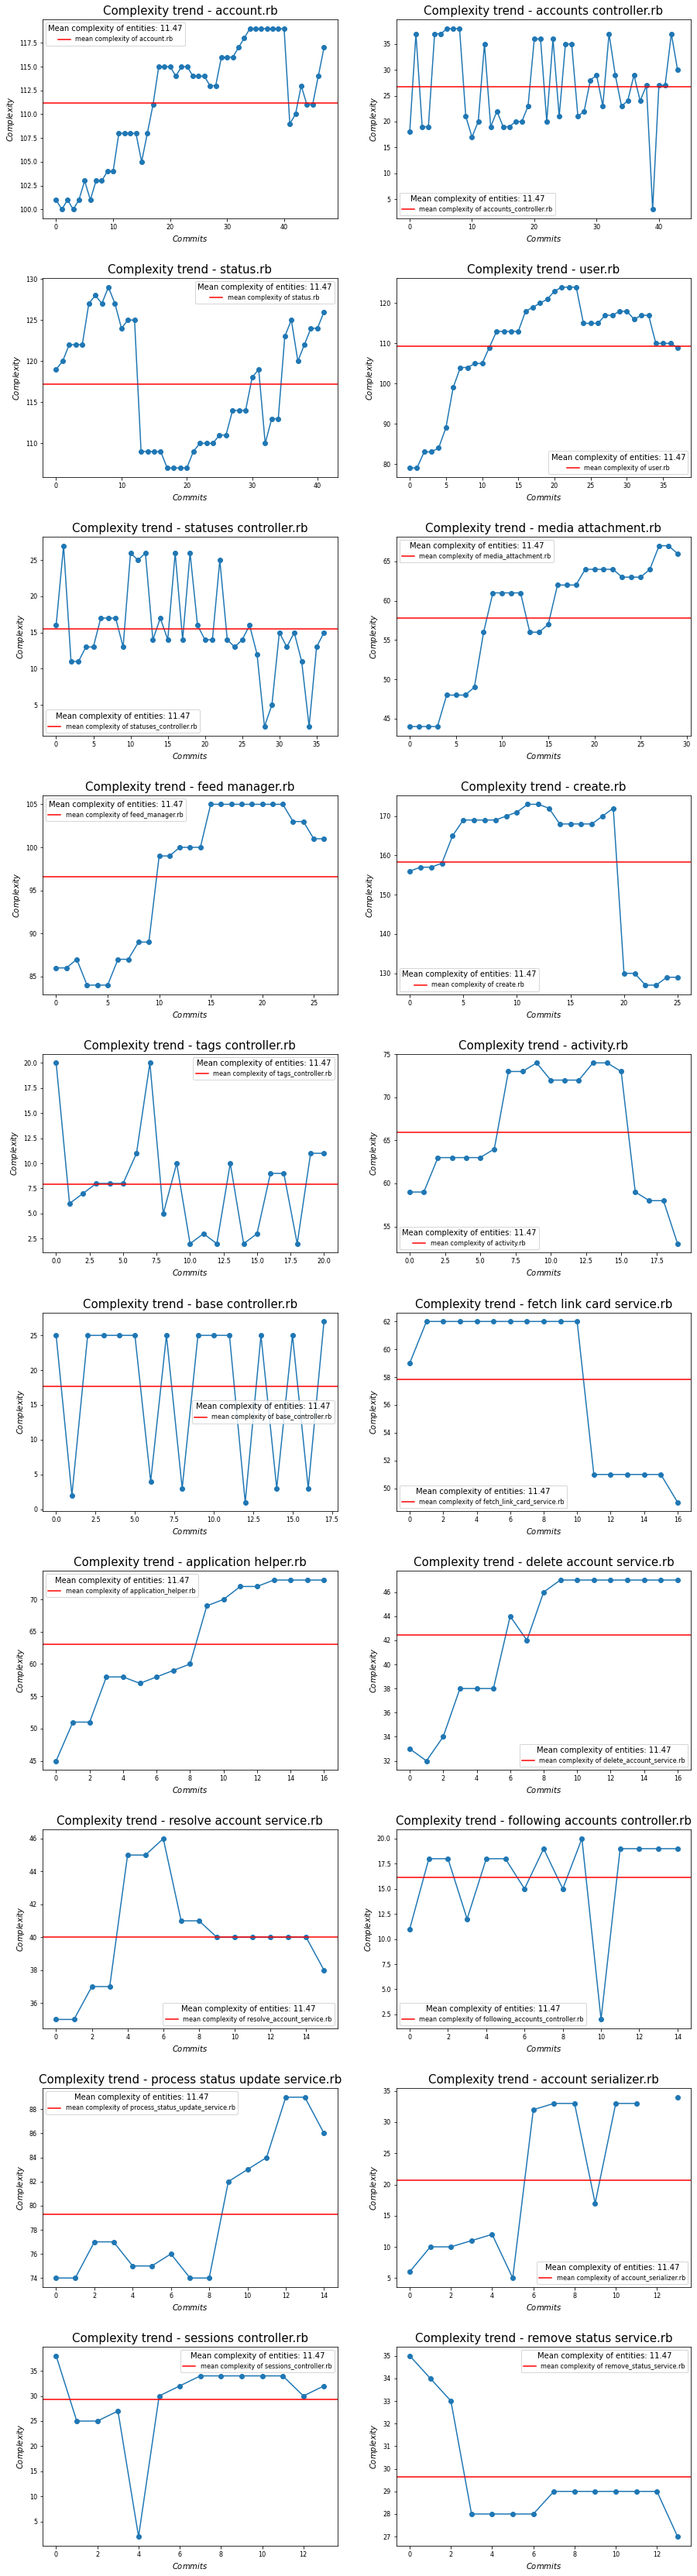

In [13]:
# we study the complexity trend of the entities which are in the top-20 with more modifications. These are our initial
# candidates to be hotspots. The complexity temporal evolution helps us to determine what are our final candidates to
# be hotspots.
number_of_hotspots = 20
plt.figure(figsize=(15, 60))
for index, ent in enumerate(entity_changes):  
    plot_complexity_trend(ent, index + 1)
    if index == number_of_hotspots - 1:
        break
# adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)
plt.show()


### 8. Analyze six candidate hotspots (not necessarily the top ones) through:
- complexity trends analysis
- manual analysis of entities names and content

- then describe whether these candidates are actual hotspots or not, your reasoning for this decision, how important it would be to fix them, and any ideas for their improvement.

<i> **Candidates to hotspots**, based on the number of changes and the complexity trend. Most of them have a complexity trend that increases with time, except create.rb, which, although its complexity decreases for the last commits (we can observe a significant drop in the complexity, most likely due to a refactor), it still has a very high complexity value.
- account.rb
- status.rb 
- user.rb 
- feed_manager.rb 
- process_status_update_service.rb
- create.rb 

During the analysis of hotspots it is also important to look at the Power of Names and Resposibility-Driven Design.
One class should have clear responsibilities and be named in descriptive and expressive way.
It is the case for our candidates, except for the class "create.rb". Just by the name of this class we can't understand what it does, for the others just by the names we already have an idea of what they might do or where they belong to. 
</i>


In [15]:
# By default, PyDriller returns the commits from the oldest to the newest. 
all_commits = list(repo.traverse_commits())
dict_complexities_v300 = {}
dict_loc_v300 = {}
dict_methods_count_v300 = {}
dict_tokens_count_v300  = {}
dict_source_code_v300 = {}

# sort the commits from the newest to the oldest
all_commits_sorted = list(repo.traverse_commits())
all_commits_sorted.sort(key=lambda x: x.committer_date, reverse=True)
dict_complexities_v353 = {}
dict_loc_v353  = {}
dict_methods_count_v353  = {}
dict_tokens_count_v353  = {}
dict_source_code_v353 = {}


def find_info(file_name, commits_to_use):
    for commit in commits_to_use:
        for m in commit.modified_files:
            if m.filename == file_name:
                if commits_to_use == all_commits:
                    print("\tEarliest commit date (v3.0.0 - v3.5.3): ", commit.committer_date)
                else:
                    print("\tLatest commit date (v3.0.0 - v3.5.3): ", commit.committer_date)
                return m.complexity, m.nloc, len(m.methods), m.token_count, m.source_code


list_of_hotspots = ['account.rb', 'status.rb', 'user.rb', 'feed_manager.rb', 'process_status_update_service.rb', 'create.rb']
for file_name in list_of_hotspots:
    print("File name: ", file_name)
    # finding the newest information about the entity 
    complexity, nloc, methods_count, token_count, source_code= find_info(file_name, all_commits_sorted)
    dict_complexities_v353[file_name] = complexity
    dict_loc_v353[file_name] = nloc
    dict_methods_count_v353[file_name] = methods_count
    dict_tokens_count_v353[file_name] = token_count
    dict_source_code_v353[file_name] = source_code
    # finding the oldest information about the entity
    complexity, nloc, methods_count, token_count, source_code = find_info(file_name, all_commits)
    dict_complexities_v300[file_name] = complexity
    dict_loc_v300[file_name] = nloc
    dict_methods_count_v300[file_name] = methods_count
    dict_tokens_count_v300[file_name] = token_count
    dict_source_code_v300[file_name] = source_code
    print("")

File name:  account.rb
	Latest commit date (v3.0.0 - v3.5.3):  2022-05-26 15:50:33+02:00
	Earliest commit date (v3.0.0 - v3.5.3):  2019-10-09 07:10:46+02:00

File name:  status.rb
	Latest commit date (v3.0.0 - v3.5.3):  2022-05-26 00:20:30+02:00
	Earliest commit date (v3.0.0 - v3.5.3):  2019-10-06 22:11:17+02:00

File name:  user.rb
	Latest commit date (v3.0.0 - v3.5.3):  2022-05-16 19:13:36+02:00
	Earliest commit date (v3.0.0 - v3.5.3):  2019-10-24 22:51:41+02:00

File name:  feed_manager.rb
	Latest commit date (v3.0.0 - v3.5.3):  2022-04-26 22:06:31+02:00
	Earliest commit date (v3.0.0 - v3.5.3):  2019-10-06 22:11:17+02:00

File name:  process_status_update_service.rb
	Latest commit date (v3.0.0 - v3.5.3):  2022-05-13 00:02:35+02:00
	Earliest commit date (v3.0.0 - v3.5.3):  2022-01-19 22:37:27+01:00

File name:  create.rb
	Latest commit date (v3.0.0 - v3.5.3):  2022-05-13 00:02:35+02:00
	Earliest commit date (v3.0.0 - v3.5.3):  2019-11-30 19:58:00+01:00



Tag v3.5.3 was created on 26.05.2022.
-----------------------------------------


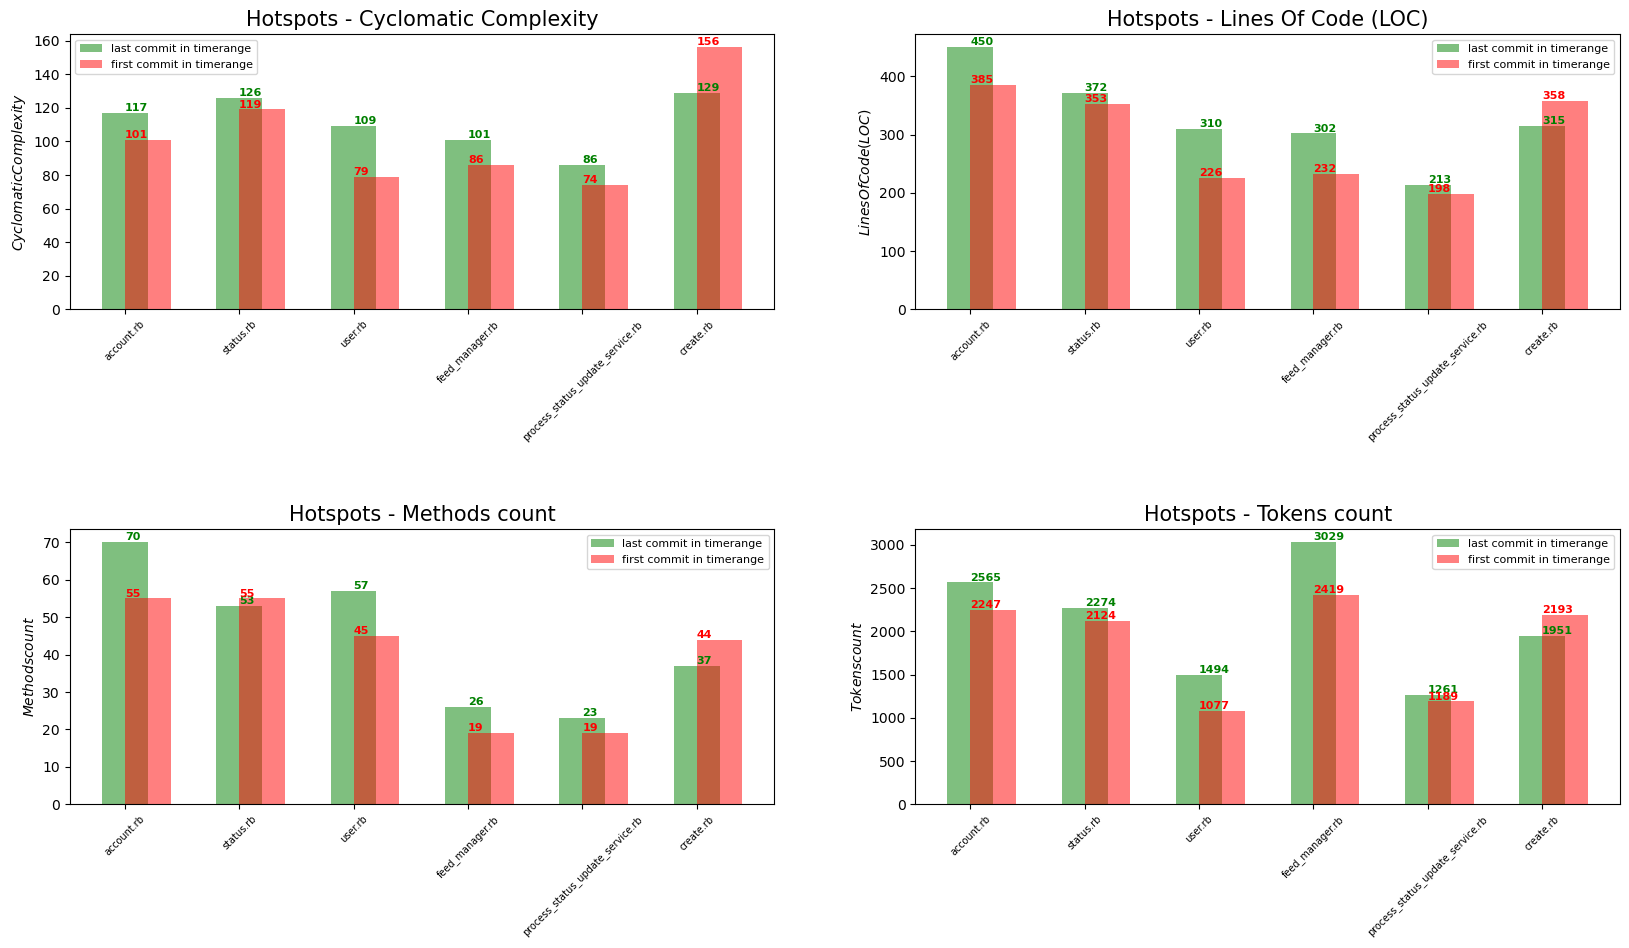

In [202]:
print("Tag v3.5.3 was created on 26.05.2022.")
print("-----------------------------------------")

# create bar plot for each measure
def create_bar_plot(measure_v353, measure_v300, measure_name, index):
    plt.subplot(2, 2, index)
    plt.bar(list_of_hotspots, measure_v353, color='green', alpha = 0.5, label="last commit in timerange", width = 0.4)
    for i, v in enumerate(measure_v353):
        plt.text(i, v, str(v), color='green', va='bottom', fontsize=8, fontweight='bold')
    # shift the bars to the right to make the difference between the two bars more visible
    x = np.arange(len(list_of_hotspots))
    plt.bar(x + 0.2, measure_v300, color='red', alpha = 0.5, label = "first commit in timerange", width = 0.4)
    for i, v in enumerate(measure_v300):
        plt.text(i, v, str(v), color='red', va='bottom', fontsize=8, fontweight='bold')
    # other settings 
    plt.title("Hotspots - " + measure_name, fontsize=15)
    plt.ylabel(r"$" + measure_name + "$", fontsize=10)
    plt.xticks(rotation=45, fontsize=7)
    plt.legend(loc='best', prop={'size': 8})

plt.figure(figsize=(20,10))
index = 1
for measure_v353, measure_v300, measure_name in zip([dict_complexities_v353, dict_loc_v353, dict_methods_count_v353, dict_tokens_count_v353], 
                                      [dict_complexities_v300, dict_loc_v300, dict_methods_count_v300, dict_tokens_count_v300],
                                      ["Cyclomatic Complexity", "Lines Of Code (LOC)", "Methods count", "Tokens count"]):
    create_bar_plot(list(measure_v353.values()), list(measure_v300.values()), measure_name, index)
    index += 1
plt.subplots_adjust(hspace=0.8)
plt.show()

In [24]:
# indent 
#def count_indents(source_code):
#    indents = []
#    splitted_lines = source_code.splitlines()
#    splitted_lines = [line.rstrip() for line in splitted_lines]
#    stripped_lines = [line for line in splitted_lines if line]
#    # count the number of indents for each line
#    for line in stripped_lines:
#        indents.append((len(line) - len(line.lstrip())))
#    return indents
#
#indents_v353 = {}
#for file_name in list_of_hotspots:
#    indents_v353[file_name] = count_indents(dict_source_code_v353[file_name])
#
#def create_bar_plot(file_name, indents, index):
#    plt.subplot(2, 3, index)
#    plt.bar(indents, indents, color='green', width = 0.4)
#    plt.title("Indents occurence - " + file_name, fontsize=15)
#    print()
#    plt.xticks(range(min(indents), max(indents)), rotation=45, fontsize=7)
#    plt.ylabel("Number of occurences", fontsize=10)
#    plt.xlabel("Indent size(1 = one whitespace)", fontsize=10)
#
#    
#
#plt.figure(figsize=(20,10))
#index = 1
#for file_name, indents in indents_v353.items():
#    create_bar_plot(file_name, indents, index)
#    index += 1
#plt.subplots_adjust(hspace=0.4)
#plt.show()

Analysis of the complexity hotspots:

- **account.rb**: it has an increasing complexity trend during the defined timeframe. There is a significant complexity drop at the end of the timeline which may indicate a refactor in the code. After this drop the complexity recovered the increasing behaviour, which could indicate a problem in the entity design.

    The obtained results showed that this entity has a large number of lines and methods. Besides, by manually inspecting the file, we can see that it contains a large number of attributes and validations, some of them, with complex expressions (regular expressions, large validations, etc). The entity contains also SQL expressions which may significantly increase the complexity of the code. This is clearly a complexity hotspot, and we consider critical to refactor it, since it could be a future source of defects. The number of lines, methods and attributes may indicate that breaking the entity or re-thinking the distribution of its responsibilities could be a solution for decreasing its complexity. On the other hand, we believe that the SQL queries should be included in a different entity.
    

- **status.rb**: this entity presents a similar behaviour to the entity account.rb: the increasing trend dominates most of the timeframe which a drop after one of the commits.

    Similarly to account.rb, this entity is large in terms of lines, methods and attributes. Also contains some SQL queries that seem to indicate that there is a mixture between domain and infrastructure code. We also consider this entity as a hotspot and the proposed solutions would be, as for account.rb, to break the class and analyse if there is a mix between business logic and infrastructure code (like the SQL queries).


- **user.rb**: the complexity trend shows a positive increment at the beginning of the analyzed period followed by a stable period. Due to its high complexity value, we have considered this entity also as a complexity hotspot.

    They analysis of this entity is comparable to the ones performed to account.rb and status.rb. All these three entities have in common that are models used for the rest of the entities. A re-design of the models could be a good solution to improve the code quality and decrease the overall complexity. Although it may be a costly modification, it could be beneficial in the long - term. Additionally, we have missed some documentation on the code to help understanding the different methods included in the entities. 
    

- **feed_manager.rb**: like user.rb, the complexity evolution shows an initial increasing period and a final stable phase. 

    This entity presents a completely different aspect respect to the model entities. The names of the methods are meaningful and they are well - documented. Besides, we do not appreciate very complex parts in the code as before. However, it is also quite a quite long entity and contains a large number of methods. Breaking the entity in smaller ones may be beneficial but we do not consider critical its refactor. We consider that the focus should be put on the previous entities we have analysed.


- **process_status_update_service.rb**: although the complexity of this entity is stable for the first commits, it starts to show a positive slope for the last phase of the timeframe.

    Like for the model entites, here we miss comments to have a better understanding of the roles of each method. On the other side, the length of the entity does not seem a big issue in this case. From the source code we observe that the entity contains some complex conditionals and code to handle external calls. Extracting the code for the external calls and refactoring the some of the conditional may reduce the overall entity complexity.
    

- **create.rb**: this entity shows the greater complexity value. However, according to its evolution we see that it is most of the time stable, except for one of the commits, which may indicate an important refactor on the code. 

    First of all, we consider that create is a bad name of the entity. While the names of the previous entities indicate their role, this one gives no clue about its functionality. Here the complexity of some of the conditional is even greater. Besides, without any documentation on the code results quite difficult to understand what the methods do. The amount of complex code and the length of the entity make us believe that it is a complexity hotspot that should be considered as a candidate to refactor. Breaking the code may be a way of achieving more cohesive entities with lower complexity.

# PART 2: Temporal/Logical Coupling

### 1. Determine what could be cases of temporal/logical coupling and generate a list of candidates with a set of coupled entities.

For the temporal/logical coupling analysis we have chosen the 15 entities that have more changes within the defined timeframe. Then, for each of these entities we store how many times the other entities have changed when changing this entity. This information allows us to look for couplings: if changing an entity implies to change another one a large number of times, this is a candidate for coupled entities.

In [14]:
# read entity_changes from pickle
entity_changes = pickle.load(open("entity_changes.pickle", "rb"))

In [15]:
max_index = 15
most_changed_files = list(entity_changes.keys())[:max_index]

coupling_matrix = np.zeros([max_index,max_index])
for c in repo.traverse_commits():
    for mf in c.modified_files:
        if mf.filename in most_changed_files:
            for mf_inner in c.modified_files:
                if mf_inner.filename in most_changed_files:
                    coupling_matrix[most_changed_files.index(mf.filename)][most_changed_files.index(mf_inner.filename)] += 1

### 2. Visualize these candidate sets of couple entities with a visualization of your choice.

With the previous data, it is easy to see for a given file, how many times the others have changed. However, it is tedious to analyse mutual coupling between different entites. With the goal of finding this patterns easily, we stored and plotted the results as a matrix. Besides, we have normalized to 1 every line of the matrix so we can compare results for different entities.

In [17]:
# normalization of the coupling matrix so we can compare different rows
normalized_coupling_matrix = np.zeros([max_index,max_index])
for index, line in enumerate(coupling_matrix):
    normalized_coupling_matrix[index] = line/line[index]

In [18]:
# save the coupling matrix to a pickle file
pickle.dump(normalized_coupling_matrix, open("coupling_matrix.pickle", "wb"))

In [19]:
# read coupling matrix from pickle
normalized_coupling_matrix = pickle.load(open("coupling_matrix.pickle", "rb"))

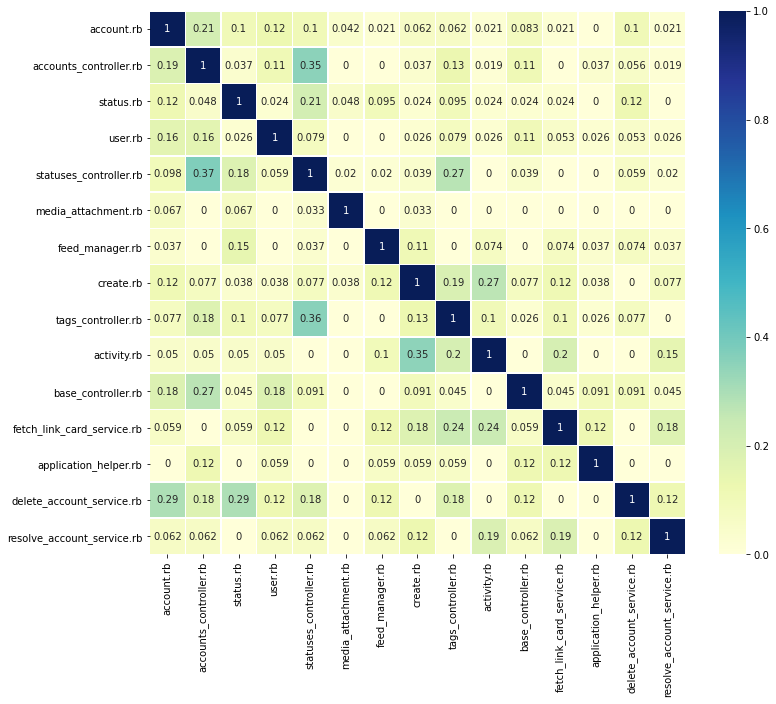

In [23]:
plt.figure(figsize=(12,10))
plt.rc('text', usetex=False)
ax = sns.heatmap(normalized_coupling_matrix, 
                 annot=True, 
                 xticklabels=most_changed_files, 
                 yticklabels=most_changed_files, 
                 cmap="YlGnBu", 
                 linewidth=0.5)

From the previous results, we have selected the three following **sets of couple entities**:
- { accounts_controller.rb, statuses_controller.rb }
- { statuses_controller.rb, tags_controller.rb }
- { create.rb, activity.rb}

### 3. For three set candidates in the list: 
- analyze and explain why these entities are coupled; 
- describe how important it would be to fix them, and any ideas for their improvement.

- a) <b> { accounts_controller.rb, statuses_controller.rb } </b>
Since Mastodon, is a free and open-source social network, we can explain what those controllers do by looking at the code and the names. The accounts_controller.rb is responsible for the accounts of different users, and the statuses_controller.rb is responsible for the activity of the account, so to say its status. So, it is not surprising that they are coupled, since they are both responsible for some part of the user's account. 
After looking inside the files, we can say that status_controller.rb is responsible for the showing and creation of new statuses. While in the accounts_controller.rb we can notice the show function that gathers different statuses(e.g. pinned statuses) present on the account and allows to filter them. 
In this example of coupling, we can see that the coupling reflects different roles such as producer and consumer. The statuses_controller.rb is the producer of the statuses, while the accounts_controller.rb is the consumer of the statuses. It is not obvious what to do in this case, as changing the structure might not be a good idea. 


- b) <b> { statuses_controller.rb, tags_controller.rb } </b>
In this case, the tags_controller.rb uses the before_action(used for structuring your business logic in a useful way) to prepare the data necessary before the action executes. One of those actions is set_statuses, which uses the status information for the account of the user. At the same time the statuses_controller.rb uses TagManager to configure the actions connected with redirections.


- c) <b> { create.rb, activity.rb} </b>
Activity.rb defines the various types of activities that can be created in an app. There are six different types of activities, each with its own specific code to handle creation, announcement, deletion, following, liking, and blocking. The create.rb file is responsible for one of them, that is e.g. status or message creation. It is not suprising that they occur together in the commit messages as one of them is just specialization of the other.
It is sure that they were created together in the development process. 






# TODO - add sth to a, b, c? 


# Part 3: Defective Hotspots

### 1. Decide on how you want to detect entities that had defects in the past (e.g., commit message analysis vs. issue tracking system analysis) and motivate your choice.

The search for hotspots was performed by analyzing commit messages. Our choice was motivated by a preliminary study of github commit messages. First, we filtered in the Issues tab all those issues that were related to bugs within our defined time frame and to changes in ruby files. From the result we checked that the associated commits were correctly indicated with keywords like "Fix" or "Fixed". Therefore, we decided to perform the analysis by checking the commit messages.

### 2. Determine defective hotspots among the entities in the timeframe that you previously selected (i.e., consider only defects in the selected timeframe). What conclusions can you draw from this?

In [16]:
# For each commits, we check if the message includes the keyword "fix". For these cases, we store in a dictionary
# the entites that have changed.

defective_files = {}
keywords = ["fix"]

for c in repo.traverse_commits():
    if any(k in c.msg.lower() for k in keywords):
        for mf in c.modified_files:
            if ".rb" in mf.filename and mf.filename in entities:
                if mf.filename not in defective_files:
                    defective_files[mf.filename] = 1
                else:
                    defective_files[mf.filename] += 1
defective_files = {k: v for k, v in sorted(defective_files.items(), key=lambda item: item[1], reverse=True)}

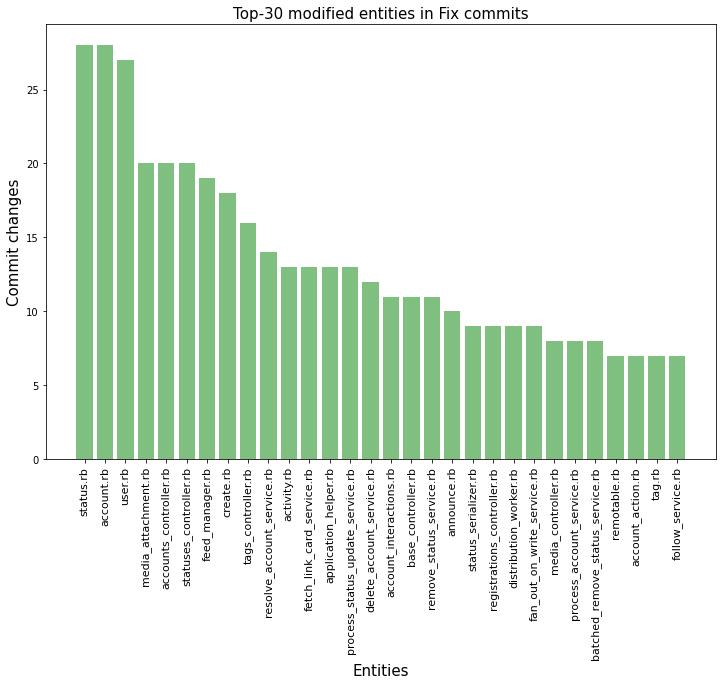

In [17]:
# For a clearer analysis of the defective hotspots, we plot the top-30 entities with more changes when the commit includes fix
def_max = 30
plt.figure(figsize=(12,8))
plt.bar(list(defective_files.keys())[:def_max], list(defective_files.values())[:def_max], color='green', alpha = 0.5)
plt.xticks(rotation=90, fontsize=11)
plt.title("Top-" + str(def_max) + " modified entities in Fix commits", fontsize=15)
plt.ylabel("Commit changes", fontsize=15)
plt.xlabel("Entities", fontsize=15)
plt.show()

In [20]:
# keywords = ["fix", "fixes", "fixed", "close", "closes", "closed",  "resolve", "resolves", "resolved"]
keywords_fix = ["fix", "fixes", "fixed"]
keywords_close = ["close", "closes", "closed"]
keywords_resolve = ["resolve", "resolves", "resolved"]

def count_defective_files(keywords):
    defective_files = {}
    for c in repo.traverse_commits():
        if any(k in c.msg.lower() for k in keywords):
            for mf in c.modified_files:
                if ".rb" in mf.filename and mf.filename in entities:
                    if mf.filename not in defective_files:
                        defective_files[mf.filename] = 1
                    else:
                        defective_files[mf.filename] += 1
    defective_files = {k: v for k, v in sorted(defective_files.items(), key=lambda item: item[1], reverse=True)}
    return defective_files

defective_files_fix = count_defective_files(keywords_fix)
defective_files_close = count_defective_files(keywords_close)
defective_files_resolve = count_defective_files(keywords_resolve)

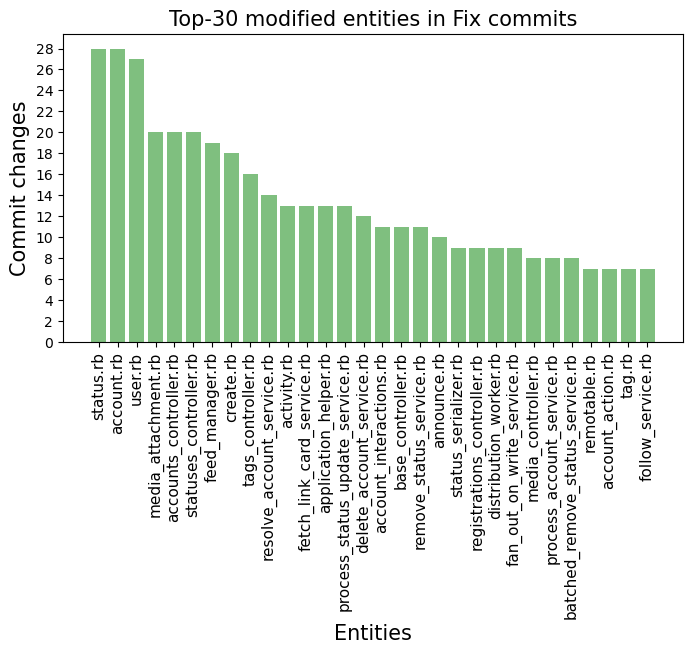

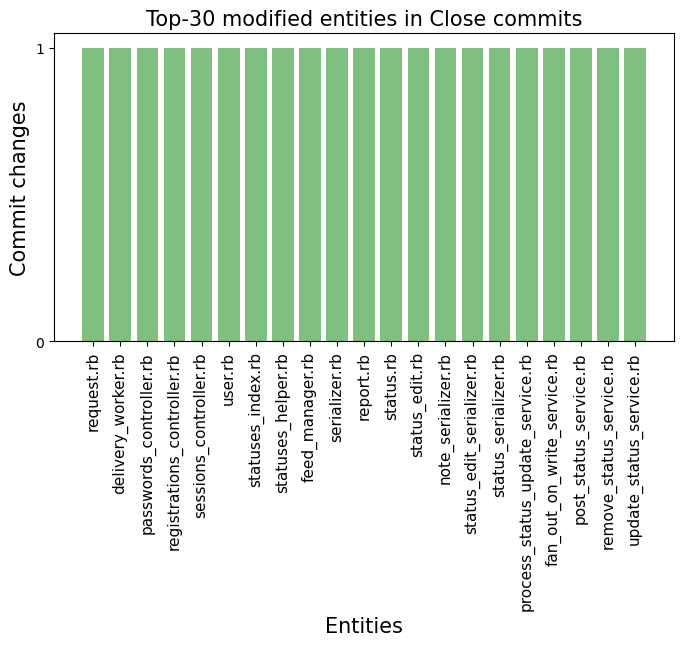

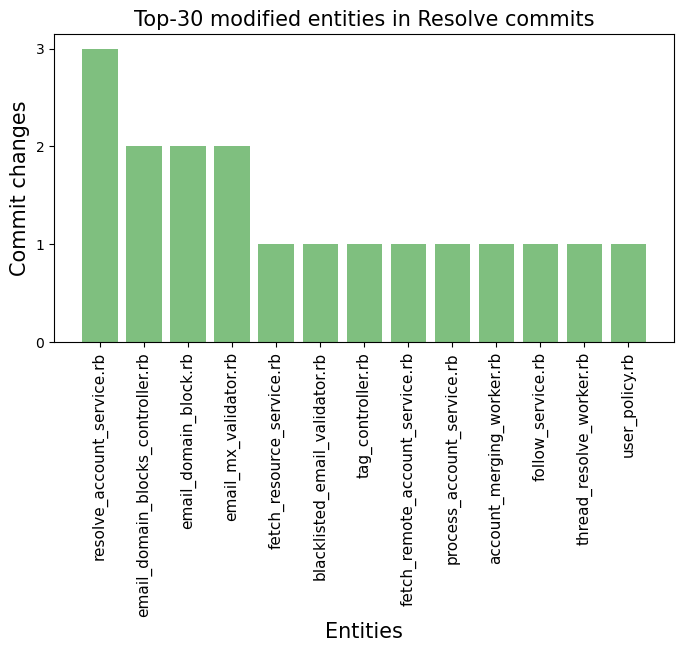

In [31]:
# For a clearer analysis of the defective hotspots, we plot the top-30 entities with more changes when the commit includes fix
def plot_defective_files(defective_files, title):
    def_max = 30
    plt.figure(figsize=(8,4))
    plt.bar(list(defective_files.keys())[:def_max], list(defective_files.values())[:def_max], color='green', alpha = 0.5)
    plt.xticks(rotation=90, fontsize=11)
    plt.title("Top-" + str(def_max) + f" modified entities in {title} commits", fontsize=15)
    plt.ylabel("Commit changes", fontsize=15)
    plt.xlabel("Entities", fontsize=15)
    if title != "Fix":
        plt.yticks(np.arange(0, max(list(defective_files.values())[:def_max])+1, 1.0))
    else:
        plt.yticks(np.arange(0, max(list(defective_files.values())[:def_max])+1, 2.0))
    plt.show()

plot_defective_files(defective_files_fix, "Fix")
plot_defective_files(defective_files_close, "Close")
plot_defective_files(defective_files_resolve, "Resolve")

### 3. Determine complexity hotspots at the beginning of your timeframe, then correlate them with the defects they have presented throughout the entire timeframe. Is there a correlation? Why do you think this is the case?

We can determine the complexity hotspots at the beginning of our timeframe from the data obtained in 1.8 (top-6).

In [18]:
complexity_records = []
for entity in dict_complexities_v300:
    complexity_records.append((entity, dict_complexities_v300[entity]))
print(tabulate(complexity_records, headers=['Entity', 'Complexity']))

Entity                              Complexity
--------------------------------  ------------
account.rb                                 101
status.rb                                  119
user.rb                                     79
feed_manager.rb                             86
process_status_update_service.rb            74
create.rb                                  156


We present the top-15 defective hotspots. For that we consider as defect every change done in what we considered before as a fix commit.

In [19]:
defective_records = []
limit_records = 15
for entity in defective_files:
    defective_records.append((entity, defective_files[entity]))
print(tabulate(defective_records[:limit_records], headers=['Entity', 'Defects']))

Entity                              Defects
--------------------------------  ---------
status.rb                                28
account.rb                               28
user.rb                                  27
media_attachment.rb                      20
accounts_controller.rb                   20
statuses_controller.rb                   20
feed_manager.rb                          19
create.rb                                18
tags_controller.rb                       16
resolve_account_service.rb               14
activity.rb                              13
fetch_link_card_service.rb               13
application_helper.rb                    13
process_status_update_service.rb         13
delete_account_service.rb                12


From the previous results, it is clear that there is a correlation between the complexity of the entites, and the number of defects they have. All the entities contained in the list of complexity hotspots are in the list of defective hotspots. Besides, the top-3 of entities with more defects are complexity hotspots. 

The data obtained show a logical result: the more complex an entity is, the greater the probability of having defects.

### 4. What conclusions can you draw from the relationship between defective hotspots and complexity hotspots in Mastodon? And on these two metrics in general?